<a href="https://colab.research.google.com/github/SreeCharan1234/Alzheimer-MRI-Classification/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/augmented-alzheimer-mri-dataset


In [4]:
path='/kaggle/input/augmented-alzheimer-mri-dataset'
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

Streaming output truncated to the last 5000 lines.
/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/9f5a254f-5a05-49d0-bf9c-b3c1713ad3d3.jpg
/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/013c7086-9972-4193-8544-31c9fbb49072.jpg
/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/5969aefe-358f-4a4b-a47e-dd44c422b619.jpg
/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/17cb5d71-978d-42d3-b8be-984714b1c619.jpg
/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/e1fa3010-6c74-45eb-a7eb-611eb1a958f5.jpg
/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/51526b66-79c4-4743-9f01-725eef9c67f7.jpg
/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/24a008c3-d5a8-4056-a392-9a0070b5083f.jpg
/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDat

In [1]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [10]:
import os
import pandas as pd

# Use 'OriginalDataset' where all class folders are available
base_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset'

# Define subdirectories and labels
class_folders = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

filepaths = []
labels = []

for i, folder in enumerate(class_folders):
    folder_path = os.path.join(base_dir, folder)
    flist = os.listdir(folder_path)
    for f in flist:
        fpath = os.path.join(folder_path, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

# Create DataFrame
Alzheimer_df = pd.DataFrame({
    "filepaths": filepaths,
    "labels": labels
})

# Show results
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())


                                           filepaths         labels
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
labels
Non Demented         3200
Very MildDemented    2240
Mild Demented         896
Moderate Demented      64
Name: count, dtype: int64


In [11]:
Alzheimer_df.shape

(6400, 2)

In [12]:
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [13]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(5120, 2)
(1920, 2)
(1280, 2)
(4480, 2)


In [14]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 5120 validated image filenames belonging to 4 classes.
Found 1920 validated image filenames belonging to 4 classes.
Found 1280 validated image filenames belonging to 4 classes.


In [15]:
classes=list(train.class_indices.keys())
print (classes)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


In [16]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

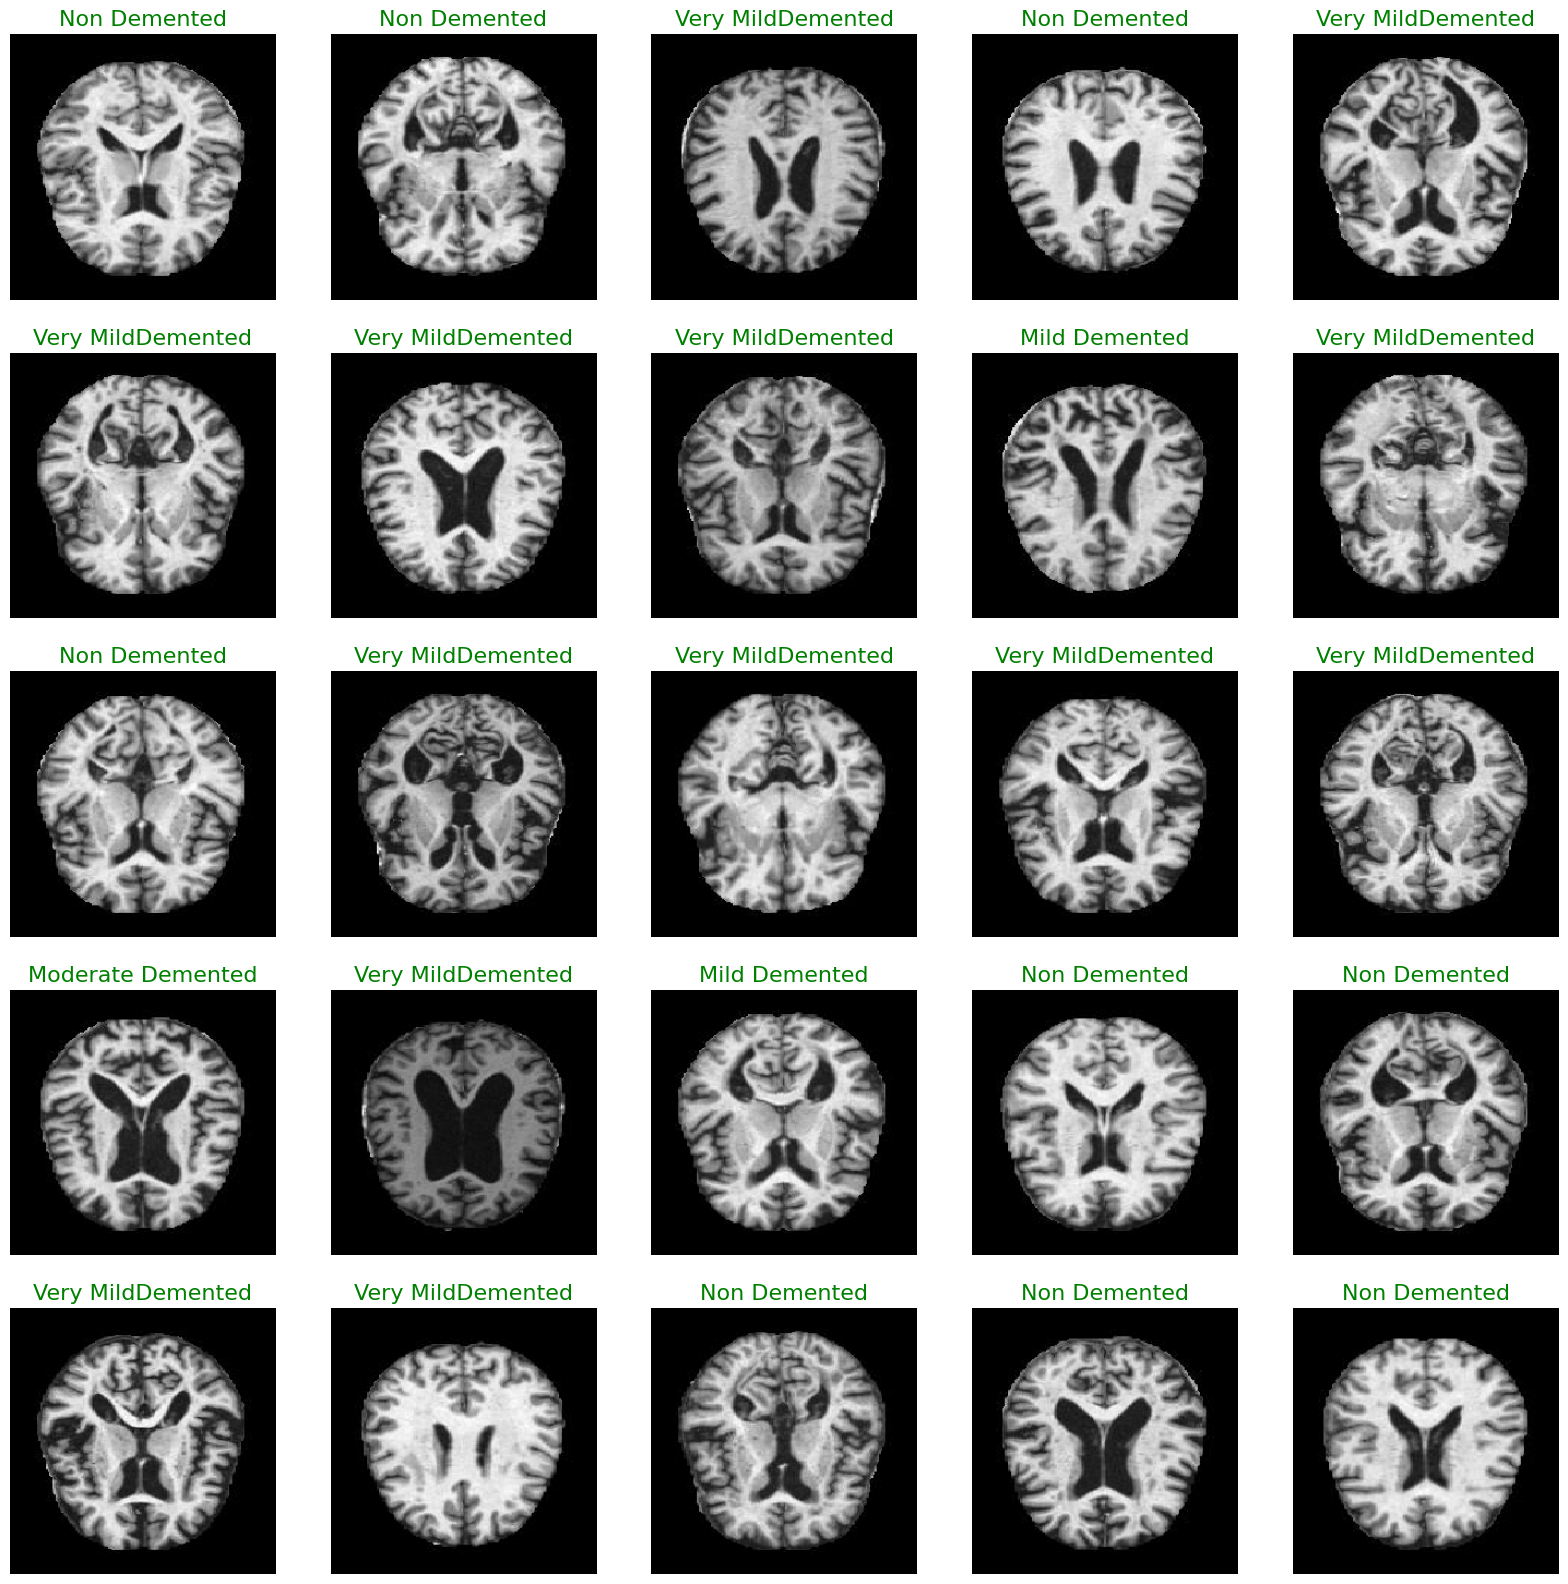

In [17]:
show_knee_images(train)

In [18]:
from tensorflow.keras.optimizers import Adamax

img_shape=(244,244,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

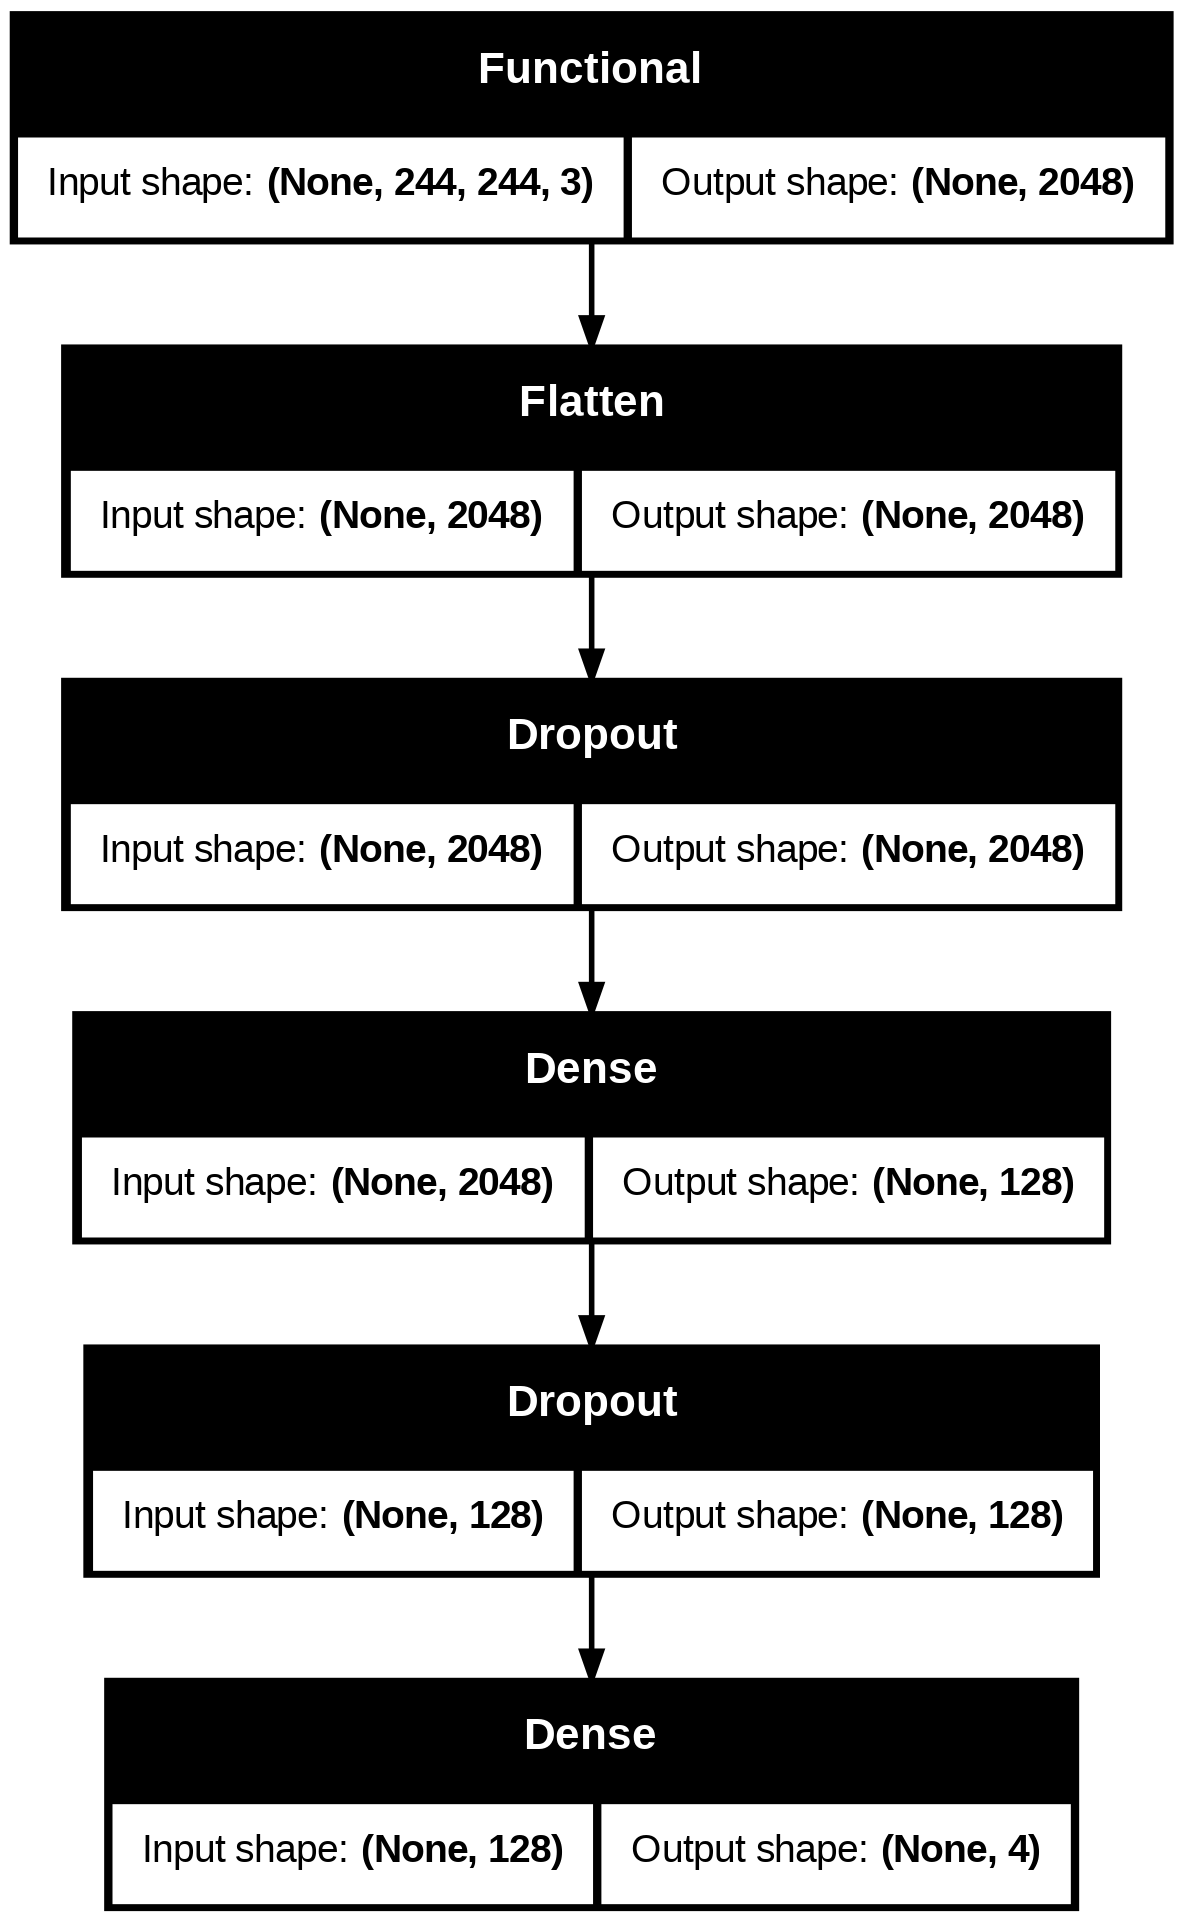

In [19]:
model.build(input_shape=(None, *img_shape))
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
history = model.fit(train, epochs=10, validation_data=val, validation_freq=1)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 157s 622ms/step - accuracy: 0.5597 - loss: 1.0699 - val_accuracy: 0.6398 - val_loss: 1.0316
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 94s 585ms/step - accuracy: 0.8813 - loss: 0.3399 - val_accuracy: 0.7539 - val_loss: 0.7542
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 94s 585ms/step - accuracy: 0.9629 - loss: 0.1133 - val_accuracy: 0.8234 - val_loss: 0.5571
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 98s 610ms/step - accuracy: 0.9787 - loss: 0.0703 - val_accuracy: 0.8609 - val_loss: 0.5883
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 94s 585ms/step - accuracy: 0.9854 - loss: 0.0393 - val_accuracy: 0.9242 - val_loss: 0.3629
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 94s 585ms/step - accuracy: 0.9876 - loss: 0.0334 - val_accuracy: 0.9500 - val_loss: 0.1641
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 93s 584ms/step - accuracy: 0.9913 - loss: 0.0238 - val_accuracy: 0.9000 - val_loss: 0.4510
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 94s 586ms/step - accuracy: 0.9869 - loss: 

In [21]:
model.evaluate(test, verbose=1)

60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.9505 - loss: 0.1989


[0.16035380959510803, 0.9588541388511658]

In [26]:
model.save("Augmented_Alzheimer_Model_95.h5")

In [27]:
from google.colab import files
files.download("Augmented_Alzheimer_Model_95.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step


In [31]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                   precision    recall  f1-score   support

    Mild Demented       0.98      0.92      0.95       283
Moderate Demented       1.00      0.80      0.89        15
     Non Demented       0.95      0.99      0.97       967
Very MildDemented       0.96      0.93      0.95       655

         accuracy                           0.96      1920
        macro avg       0.97      0.91      0.94      1920
     weighted avg       0.96      0.96      0.96      1920

Accuracy of the Model: 95.9%


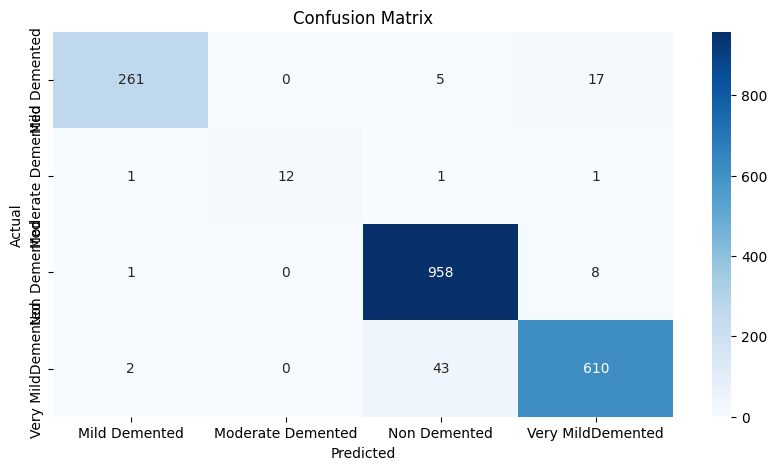

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()